This is a Machine Learning: Linear Regression Project
The Aim of the project is to create a model to predict household prices.

In [268]:
#Clean Memory
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from function_file import clean_names


Import Dataframe house_price.csv, then apply clean_names to clean column names

In [269]:
raw_df = pd.read_csv(r"data_in\house_price.csv").rename(columns = clean_names)

# Make a copy from the raw data
df = raw_df.copy()
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

No Missing values (NaN) within raw dataframe

There is only 1 unique entry for country, and 2 unique value for water front.

Actions
- Convert "waterfront" into boolean type.
- Drop "country" due to 1 unique value has no impact on our predictive analysis. 
- Drop "date" as it only contains 2 months worth of data.
- In addition, for simplicity, we are going to drop "street","statezip" columns.
- (That being said, timeframe and location does influence the house pricing.) 
- Apply log transform to price columns

In [270]:
# Check NA, No NAs for this dataframe
print("NA Counts: ", df.isnull().sum())
#Check unique Observations for each columns
print(df.nunique().reset_index().sort_values(by=0))

# Drop Country & Date
df.drop(columns = ["country", "date", "street","statezip"], inplace = True);
# Convert Water front into boolean type as it only contains 2 unique obervations
df["waterfront"] = df["waterfront"].astype('bool')

NA Counts:  date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64
            index     0
17        country     1
7      waterfront     2
9       condition     5
8            view     5
6          floors     6
2        bedrooms    10
3       bathrooms    26
15           city    44
13   yr_renovated    60
0            date    70
16       statezip    77
12       yr_built   115
11  sqft_basement   207
10     sqft_above   511
4     sqft_living   566
1           price  1741
5        sqft_lot  3113
14         street  4525


Predictor EDA

In the histogram below, we observed that there are 49 entries with Pricing equal to 0.
In real world, we could need to find / ask to refine the zero entries.

For this excercise, we can utilise those price = $0.00 as our predicting subjects.

In [271]:
# We will be using the price $0.00 house as our predicted subjects
df_use_for_prediction = df.loc[df["price"]== 0]

# Excluding £0.00 from the main dataframe.
df = df.loc[df["price"]!=0]

The housing pricing disturbution has a skewness of 25 which indicates the following:
- Highly, Positive Askew (skewness >> 0)
- Outliner has a high influence in predictive outcome
- Majority of the data point lays on the lower end, creating a bias

Thereform applying log transformation to convert as

Price Skewness 25.015568709381817


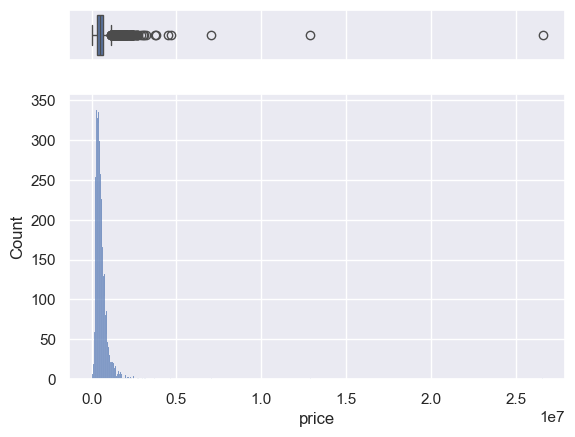

In [272]:
from scipy.stats import skew

print("Price Skewness", format(skew(df["price"])))

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(df["price"], orient="h", ax=ax_box)
sns.histplot(data=df, x="price", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

Applying Log Transformation to transform pricing into a normal disturbution.

In [273]:
df["log_price"] = np.log(df["price"])

# Rearrange log_price column to the start of dataframe
first_column = df.pop('log_price') 
df.insert(0,'log_price', first_column)

Price Skewness 0.3298726126818522


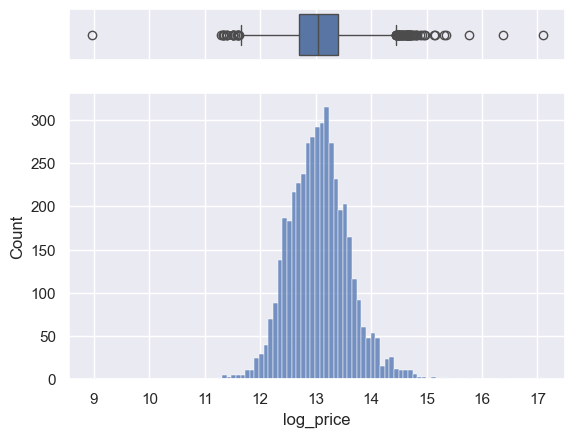

In [274]:
log_price = pd.DataFrame(np.log(df["log_price"]))

print("Price Skewness", format(skew(df["log_price"])))

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(df["log_price"], orient="h", ax=ax_box)
sns.histplot(data = df, x="log_price", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

Numerical Feature Selections


2. Assumption that R2 >=|0.6|, indicate colinearity between features.
3. Assumption that R2 >=|0.1|, indicate that there is no direct correlation between predictor & features

<br>Numerical Features Summary (Sorted by R2):

<br>Features         R2
<br>sqft_living      0.671 ✔ 
<br>sqft_above       0.582 X (Collinearity with sqft_living)
<br>bathrooms        0.549 X (Collinearity with sqft_living)
<br>bedrooms         0.355 ✔
<br>view             0.324 ✔
<br>sqft_basement    0.313 ✔
<br>floors           0.305 ✔
<br>sqft_lot         0.086 X (R2 shows no correlation)
<br>condition        0.059 X (R2 shows no correlation)
<br>yr_built         0.059 X (R2 shows no correlation)
<br>yr_renovated    -0.063 X (R2 shows no correlation)

In [275]:
df_numeric_feat = df.copy()
# Remove Price column
df_numeric_feat = df_numeric_feat.drop(["price"],axis = 1)
df_numeric_feat = df_numeric_feat.select_dtypes(['int64','float64'])

# Create Correlation Matrix for the numerical variable
corr = df_numeric_feat.corr().round(3)
corr_sort = corr.sort_values(by = ["log_price"], ascending = False)
print(corr_sort["log_price"])
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

log_price        1.000
sqft_living      0.671
sqft_above       0.582
bathrooms        0.549
bedrooms         0.355
view             0.324
sqft_basement    0.313
floors           0.305
sqft_lot         0.086
condition        0.059
yr_built         0.059
yr_renovated    -0.063
Name: log_price, dtype: float64


,log_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
log_price,1.000,0.355,0.549,0.671,0.086,0.305,0.324,0.059,0.582,0.313,0.059,-0.063
bedrooms,0.355,1.000,0.548,0.596,0.071,0.176,0.115,0.023,0.486,0.335,0.141,-0.062
bathrooms,0.549,0.548,1.000,0.757,0.109,0.490,0.206,-0.121,0.687,0.296,0.464,-0.218
sqft_living,0.671,0.596,0.757,1.000,0.213,0.344,0.309,-0.063,0.876,0.450,0.285,-0.122
sqft_lot,0.086,0.071,0.109,0.213,1.000,0.004,0.073,0.001,0.219,0.036,0.049,-0.021
floors,0.305,0.176,0.490,0.344,0.004,1.000,0.032,-0.274,0.522,-0.255,0.467,-0.236
view,0.324,0.115,0.206,0.309,0.073,0.032,1.000,0.063,0.175,0.317,-0.066,0.026
condition,0.059,0.023,-0.121,-0.063,0.001,-0.274,0.063,1.000,-0.177,0.197,-0.399,-0.184
sqft_above,0.582,0.486,0.687,0.876,0.219,0.522,0.175,-0.177,1.000,-0.038,0.406,-0.161
sqft_basement,0.313,0.335,0.296,0.450,0.036,-0.255,0.317,0.197,-0.038,1.000,-0.163,0.047


Feature Selection: Water Front & Cities

Categorical Features

Features              R2
<br>waterfront            0.142
<br>city_Bellevue         0.225
<br>city_Mercer Island    0.202
<br>city_Sammamish        0.127
<br>city_Redmond          0.126
<br>city_Medina           0.117
<br>city_Maple Valley    -0.100
<br>city_Tukwila         -0.105
<br>city_Covington       -0.108
<br>city_Des Moines      -0.111
<br>city_Renton          -0.139
<br>city_Federal Way     -0.175
<br>city_Kent            -0.179
<br>city_Auburn          -0.192

1. Waterfront shows correlation with the house pricing.
2. For the list of cities that has correlation with log_price This could be a confound feature since it is related to the area/zip code/school/network rather than city itself. 

In [276]:
df_feat_waterfront = df[["log_price","waterfront"]].copy()
feat_corr = df_feat_waterfront.corr().round(3)

print(feat_corr["log_price"])
feat_corr.style.format(precision=3).background_gradient(cmap='coolwarm')

log_price     1.000
waterfront    0.142
Name: log_price, dtype: float64


,log_price,waterfront
log_price,1.000,0.142
waterfront,0.142,1.000


In [277]:
df_feat_city = df[['log_price', 'city']].copy()

# Apply One-Hot Encoding to the city
df_feat_city = pd.get_dummies(df_feat_city, prefix = ["city"], columns = ["city"])

corr = df_feat_city.corr().round(3)
# Since it is high density observations, hence we are doing prefilter |R2| >= 0.1
corr = corr[corr["log_price"].abs()>=0.1]
# Sort by Correlation
corr_sort = corr.sort_values(by = ["log_price"], ascending = False)

corr_sort["log_price"]

log_price             1.000
city_Bellevue         0.225
city_Mercer Island    0.202
city_Sammamish        0.127
city_Redmond          0.126
city_Medina           0.117
city_Maple Valley    -0.100
city_Tukwila         -0.105
city_Covington       -0.108
city_Des Moines      -0.111
city_Renton          -0.139
city_Federal Way     -0.175
city_Kent            -0.179
city_Auburn          -0.192
Name: log_price, dtype: float64

Gather All Numerical and Categorical Features


Features Summary:

Features               R2
<br>sqft_living      0.671 ✔ 
<br>bedrooms         0.355 ✔
<br>view             0.324 ✔
<br>sqft_basement    0.313 ✔
<br>floors           0.305 ✔

<br>city_Bellevue         0.225
<br>city_Mercer Island    0.202
<br>city_Federal Way     -0.175
<br>city_Kent            -0.179
<br>city_Auburn          -0.192

In [278]:
screen_features = ['log_price','sqft_living','bedrooms','view','sqft_basement','floors','city']
corr_city = ['Bellevue', 'Mercer Island','Federal Way', 'Kent', 'Auburn']

#Gather all screened feature
df_feat = df[screen_features].copy()

# One Hot Encoding for correlated_ctiies
df_feat['corr_city'] = np.where(df_feat['city'].isin(corr_city), df_feat['city'], "Other")

df_feat = pd.get_dummies(df_feat, prefix = ["city_"], columns = ["corr_city"])

# Drop City Column
df_feat.drop(columns = ["city"], inplace = True)

# Create Correlation Matrix for the numerical variable
corr = df_feat.corr().round(2)
corr_sort = corr.sort_values(by = ["log_price"], ascending = False)
print(corr_sort["log_price"])
corr.style.format(precision=2).background_gradient(cmap='coolwarm')

log_price              1.00
sqft_living            0.67
bedrooms               0.36
view                   0.32
sqft_basement          0.31
floors                 0.31
city__Bellevue         0.22
city__Mercer Island    0.20
city__Other            0.06
city__Federal Way     -0.18
city__Kent            -0.18
city__Auburn          -0.19
Name: log_price, dtype: float64


,log_price,sqft_living,bedrooms,view,sqft_basement,floors,city__Auburn,city__Bellevue,city__Federal Way,city__Kent,city__Mercer Island,city__Other
log_price,1.00,0.67,0.36,0.32,0.31,0.31,-0.19,0.22,-0.18,-0.18,0.20,0.06
sqft_living,0.67,1.00,0.60,0.31,0.45,0.34,-0.02,0.15,-0.01,-0.03,0.16,-0.11
bedrooms,0.36,0.60,1.00,0.12,0.34,0.18,0.00,0.12,0.02,0.01,0.11,-0.13
view,0.32,0.31,0.12,1.00,0.32,0.03,-0.03,0.05,-0.01,-0.05,0.10,-0.02
sqft_basement,0.31,0.45,0.34,0.32,1.00,-0.26,-0.07,0.12,-0.01,-0.05,0.10,-0.04
floors,0.31,0.34,0.18,0.03,-0.26,1.00,-0.02,-0.06,-0.06,-0.02,0.02,0.07
city__Auburn,-0.19,-0.02,0.00,-0.03,-0.07,-0.02,1.00,-0.05,-0.04,-0.04,-0.03,-0.41
city__Bellevue,0.22,0.15,0.12,0.05,0.12,-0.06,-0.05,1.00,-0.05,-0.05,-0.03,-0.53
city__Federal Way,-0.18,-0.01,0.02,-0.01,-0.01,-0.06,-0.04,-0.05,1.00,-0.04,-0.02,-0.37
city__Kent,-0.18,-0.03,0.01,-0.05,-0.05,-0.02,-0.04,-0.05,-0.04,1.00,-0.03,-0.42


In [279]:
# Commented out due to long run time
# sns.pairplot(df_feat)

Baseline Model

1. Applying Standard Scaler as there outliner influencing 
1. Create a Baseline Model where used pricing ~ sqft_living (highest correlation |R2|)
- model_baseline, R2 = 0.449

In [280]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Linear Regression Model
lm = LinearRegression()

X = df_feat.drop("log_price", axis = 1)
y = df_feat["log_price"]

# Split Model into Train, Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lm.fit(X_train, y_train)

pred = lm.predict(X_test)
lm.score(X_test, y_test)

print("log_price ~ sqft_living (Baseline)", r2_score(y_test,pred).round(3))

log_price ~ sqft_living (Baseline) 0.593


In [281]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['sqft_living', 'bedrooms', 'view', 'sqft_basement', 'floors']

#Linear Regression Model
lm = LinearRegression()

# Standard Scaler (Standard Normal)
scaler = StandardScaler()

X_scaled = df_feat.copy()

#Remove Predictor Columns
X_scaled = X_scaled.drop("log_price", axis = 1)
# Scale Numeric Columns
X_scaled[columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])

In [282]:
# X = X_scaled[['sqft_living']]
# y = df_feat[["log_price"]]

# Split Model into Train, Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

lm.fit(X_train, y_train)

pred = lm.predict(X_test)
lm.score(X_test, y_test)

print("Baseline_Model Model Score: ", r2_score(y_test,pred).round(3))

Baseline_Model Model Score:  0.593


Feature 0: 2984.572159
Feature 1: 521.160104
Feature 2: 389.675980
Feature 3: 355.881507
Feature 4: 400.089838
Feature 5: 129.899154
Feature 6: 192.217232
Feature 7: 110.309682
Feature 8: 111.873952
Feature 9: 140.165313
Feature 10: 10.873673


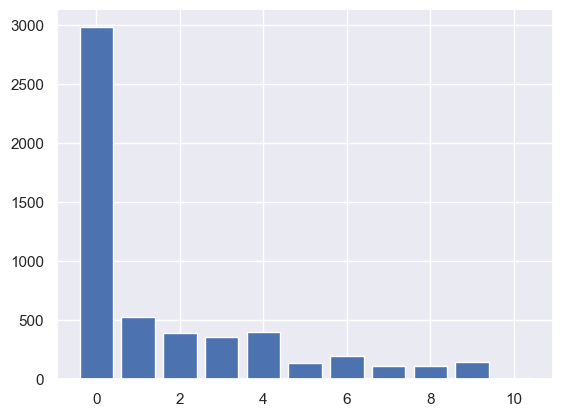

In [283]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [284]:
output = pd.DataFrame({"actual_price":np.exp(y_test), 'predicted_price':np.exp(pred)})
output["error"] = output["predicted_price"] - output["actual_price"]
output["abs_error"] = abs(output["error"])
output["abs_error_percent"] = round(output["abs_error"] /output["actual_price"]*100,0)

median_error = output["abs_error"].median()
median_house_price = output["actual_price"].median()

error_percent = round((median_error/median_house_price)*100,0)

print("median house price is $", median_house_price, "and median error is $",median_error, "with an error percentage of ", error_percent, "%")

median house price is $ 474900.0 and median error is $ 87917.79857324186 with an error percentage of  19.0 %


Summary

